# install & Git clone

In [3]:
! pip install pytorch-lightning

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 869.5/869.5 kB 37.3 MB/s eta 0:00:00


In [4]:
!apt-get install tree

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  tree
0 upgraded, 1 newly installed, 0 to remove and 49 not upgraded.
Need to get 47.9 kB of archives.
After this operation, 116 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tree amd64 2.0.2-1 [47.9 kB]
Fetched 47.9 kB in 1s (86.6 kB/s)
Selecting previously unselected package tree.
(Reading database ... 123629 files and directories currently installed.)
Preparing to unpack .../tree_2.0.2-1_amd64.deb ...
Unpacking tree (2.0.2-1) ...
Setting up tree (2.0.2-1) ...
Processing triggers for man-db (2.10.2-1) ...


In [5]:
# 2. GitHub 레포지토리 설치
!git clone https://github.com/HaeinGeek/CancerSubtypesAI.git

Cloning into 'CancerSubtypesAI'...
remote: Enumerating objects: 518, done.
remote: Counting objects: 100% (108/108), done.
remote: Compressing objects: 100% (57/57), done.
remote: Total 518 (delta 61), reused 91 (delta 51), pack-reused 410 (from 1)
Receiving objects: 100% (518/518), 43.46 MiB | 13.54 MiB/s, done.
Resolving deltas: 100% (260/260), done.
Updating files: 100% (37/37), done.


In [6]:
# 3. 작업 디렉터리 이동
%cd CancerSubtypesAI

/content/CancerSubtypesAI


In [7]:
!tree /content/CancerSubtypesAI

/content/CancerSubtypesAI
├── data
│   ├── amino_acid_features.csv
│   ├── genes_ensembl.txt
│   ├── genes_ncbi.txt
│   ├── genes_pdb.txt
│   ├── genes_uniprot.txt
│   ├── processed
│   │   ├── mutant_seq_not_found.csv
│   │   ├── mutant_seq_unique.zip
│   │   ├── protein_sequences_ensembl.csv
│   │   ├── protein_sequences_ncbi.csv
│   │   ├── protein_sequences_pdb.csv
│   │   ├── protein_sequences_uniprot.csv
│   │   └── train_mutation_encoding.csv
│   ├── samples
│   │   └── train.csv
│   └── train.csv
├── encoder
│   ├── __init__.py
│   ├── mutation_encoder.py
│   └── README.md
├── README.md
├── requirements.txt
├── scripts
│   ├── encode_mutations.py
│   ├── fetch_sequence.py
│   └── generate_mutants.py
├── sequence_fetcher
│   ├── ensembl_api.py
│   ├── __init__.py
│   ├── ncbi_api.py
│   ├── pdb_api.py
│   ├── README.md
│   ├── sequence_fetcher.py
│   └── uniprot_api.py
├── sequence_processor
│   ├── __init__.py
│   ├── mutant_generator.py
│   ├── README.md
│   └── sequence_loade

In [8]:
# 4. PYTHONPATH 설정 (processing 모듈을 패키지로 인식하도록)
import sys
sys.path.append("/content/CancerSubtypesAI")

In [147]:
! mkdir -p checkpoints
! mkdir -p logs

# 파일 불러오기

In [125]:
# 라이브러리 임포트
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchmetrics import F1Score
from sklearn.metrics import accuracy_score, f1_score

In [ ]:
import pytorch_lightning as pl
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint, LearningRateMonitor
from pytorch_lightning.loggers import CSVLogger

In [126]:
input_filepath = 'data/train.csv'
mutation_encoding_filepath= 'data/processed/train_mutation_encoding.csv'

In [127]:
train_df = pd.read_csv(input_filepath)
mutation_encoding_df = pd.read_csv(mutation_encoding_filepath)

In [128]:
# train melting
melted_df = train_df.melt(id_vars=['ID','SUBCLASS'], var_name='gene', value_name='mutation_str')
# 변이 정보 가진 행만 추출
melted_df_del_WT = melted_df[melted_df.mutation_str != 'WT']

In [129]:
# 아미노산 특성 데이터 결합
merged_df = melted_df_del_WT.merge(mutation_encoding_df, on=['gene','mutation_str'], how='left')

In [130]:
# 데이터프레임 저장 과정에서 문자열로 변환된 position 값을 리스트로 변환
import ast
merged_df.position = merged_df.position.apply(ast.literal_eval)

# 데이터셋 구조화

In [131]:
genes = train_df.drop(['ID', 'SUBCLASS'], axis=1).columns
gene_to_id = {gene: idx + 1 for idx, gene in enumerate(genes)}  # 패딩값을 0으로 사용하기 위해 1부터 시작
print(len(genes), len(gene_to_id))

4384 4384


In [132]:
mutation_types = ['Missense', 'Nonsense','Frameshift',
       'Silent_Nonsense', 'Silent_Missense', 'Deletion', 'Complex_mutation']

type_to_code = {mutation_type: idx + 1 for idx, mutation_type in enumerate(mutation_types)}  # 패딩값을 0으로 사용하기 위해 1부터 시작
type_to_code

{'Missense': 1,
 'Nonsense': 2,
 'Frameshift': 3,
 'Silent_Nonsense': 4,
 'Silent_Missense': 5,
 'Deletion': 6,
 'Complex_mutation': 7}

In [133]:
max_genes = 128
num_features_per_gene = 14
max_positions = 5
sample_ids = train_df.ID.unique()

In [134]:
# 모든 샘플 데이터를 모을 빈 리스트 생성
all_samples_data = []

for sample_id in sample_ids:
    sample_data = np.full((max_genes, num_features_per_gene), fill_value=0, dtype=np.float32)

    # 해당 샘플의 변이 정보 가져오기
    sample_mutations = merged_df[merged_df['ID'] == sample_id]

    # 모든 유전자가 WT 인 경우 gene_id = 0으로 패딩된 입력 그대로 사용
    if sample_mutations.empty:
        all_samples_data.append(sample_data)

    else:
        # max_genes 개수로 변이 유전자 수 제한
        # 변이 수가 max_genes 를 초과하는 경우 mut_num 이 많은 유전자부터 처리
        sample_mutations = sample_mutations.sort_values(by='mut_num', ascending=False).head(max_genes)

        for idx, (_, mutation) in enumerate(sample_mutations.iterrows()):
            gene_id = gene_to_id.get(mutation['gene'], 0)
            mutation_type_code = type_to_code.get(mutation['type'], 0)

            # position list 다루기
            positions = mutation['position']  # 리스트 형식

            # Padding & max_positions 까지 trauncate
            positions = (positions + [0]*max_positions)[:max_positions]

            # features 채워넣기
            features = [
                gene_id,
                mutation_type_code,
                mutation['mut_num'],
                mutation['status'],
                mutation['hydrophobicity'],
                mutation['polarity'],
                mutation['mw'],
                mutation['pI'],
                mutation['charge']
            ] + positions[:max_positions]

            sample_data[idx] = features

        all_samples_data.append(sample_data)

# NumPy array로 변환
all_samples_data = np.array(all_samples_data)  # Shape: (num_samples, max_genes, num_features_per_gene)

# position 정규화
# 유효한 position 값에 대한 마스크 생성 (패딩 값이 0인 경우)
valid_positions = all_samples_data[:, :, -max_positions:] != 0

# 패딩된 위치를 NaN으로 대체
positions_with_nan = np.where(valid_positions, all_samples_data[:, :, -max_positions:], np.nan)

# 위치별 최대값 계산 (NaN 제외)
max_pos = np.nanmax(positions_with_nan, axis=(0, 1))

# 최대값이 0인 경우 1로 대체
max_pos = np.where(max_pos == 0, 1, max_pos)

# 패딩된 위치 제외하고 정규화
all_samples_data[:, :, -max_positions:] = np.where(
    valid_positions,
    all_samples_data[:, :, -max_positions:] / max_pos,
    all_samples_data[:, :, -max_positions:]  # 패딩 값은 0으로 유지
)

In [135]:
# target 추출
subclass_mapping = {subclass: idx for idx, subclass in enumerate(train_df['SUBCLASS'].unique())}
sample_targets = []

for sample_id in sample_ids:
    sample_subclass = train_df[train_df['ID'] == sample_id]['SUBCLASS'].iloc[0]
    subclass_code = subclass_mapping[sample_subclass]
    sample_targets.append(subclass_code)

sample_targets = np.array(sample_targets)

In [136]:
print("all_samples_data shape:", all_samples_data.shape)  # Expected: (num_samples, max_genes, num_features_per_gene)
print("sample_targets shape:", sample_targets.shape)      # Expected: (num_samples,)


all_samples_data shape: (6201, 128, 14)
sample_targets shape: (6201,)


# 모델링 (Trainer)

In [138]:
# 하이퍼파라미터 설정
num_genes = len(gene_to_id) + 1  # gene_id가 1부터 시작하고 패딩 값이 0인 경우
num_types = len(type_to_code) + 1  # type이 1부터 시작하고 패딩 값이 0인 경우
num_features = num_features_per_gene - 2  # gene_id와 type을 제외한 나머지 특성 수
num_classes = len(subclass_mapping)  # SUBCLASS의 클래스 수
max_genes = all_samples_data.shape[1]

embedding_dim = 64
hidden_dim = 256
learning_rate = 0.001
batch_size = 64

early_stopping_patience = 5
learning_rate_patience = 3

In [139]:
# 손실 함수, 옵티마이저 설정
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

## 모델

In [140]:
class GeneMutationModel(pl.LightningModule):
    def __init__(self, num_genes, num_types, embedding_dim, num_features, hidden_dim, num_classes):
        super(GeneMutationModel, self).__init__()
        self.num_classes = num_classes

        # 모델 아키텍처 정의
        self.gene_embedding = nn.Embedding(num_genes, embedding_dim, padding_idx=0)
        self.type_embedding = nn.Embedding(num_types, embedding_dim, padding_idx=0)
        self.feature_fc = nn.Linear(num_features, embedding_dim)
        self.fc = nn.Sequential(
            nn.Linear(embedding_dim * 3, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, num_classes)
        )
        # 손실 함수 정의
        self.criterion = nn.CrossEntropyLoss()

        # f1 스코어로 모델 평가
        self.train_f1 = F1Score(task='multiclass', num_classes=self.num_classes, average='macro')
        self.val_f1 = F1Score(task='multiclass', num_classes=self.num_classes, average='macro')
        self.test_f1 = F1Score(task='multiclass', num_classes=self.num_classes, average='macro')

    def forward(self, x):
        # forward 메서드 구현
        gene_ids = x[:, :, 0].long()
        types = x[:, :, 1].long()
        other_features = x[:, :, 2:]

        gene_embeds = self.gene_embedding(gene_ids)
        type_embeds = self.type_embedding(types)
        feature_embeds = self.feature_fc(other_features)

        # combined_embeds = gene_embeds + type_embeds + feature_embeds (크기 불일치)
        combined_embeds = torch.cat([gene_embeds, type_embeds, feature_embeds], dim=-1)

        mask = (gene_ids != 0).unsqueeze(-1)  # 패딩 값이 0인 경우
        combined_embeds = combined_embeds * mask

        gene_agg = combined_embeds.sum(dim=1) / mask.sum(dim=1).clamp(min=1)

        out = self.fc(gene_agg)

        # for debugging
        # print("gene_embeds shape:", gene_embeds.shape)
        # print("type_embeds shape:", type_embeds.shape)
        # print("feature_embeds shape:", feature_embeds.shape)
        # print("combined_embeds shape:", combined_embeds.shape)
        # print("gene_agg shape:", gene_agg.shape)

        return out

    def training_step(self, batch, batch_idx):
        inputs = batch['sample']
        targets = batch['target']

        outputs = self(inputs)
        loss = self.criterion(outputs, targets)

        preds = torch.argmax(outputs, dim=1)
        acc = (preds == targets).float().mean()
        f1 = self.train_f1(preds, targets)

        # 로그 기록
        self.log('train_loss', loss, on_step=False, on_epoch=True)
        self.log('train_acc', acc, on_step=False, on_epoch=True)
        self.log('train_f1', f1, on_step=False, on_epoch=True)

        return loss

    def validation_step(self, batch, batch_idx):
        inputs = batch['sample']
        targets = batch['target']

        outputs = self(inputs)
        loss = self.criterion(outputs, targets)

        preds = torch.argmax(outputs, dim=1)
        acc = (preds == targets).float().mean()
        f1 = self.val_f1(preds, targets)

        # 로그 기록
        self.log('val_loss', loss, on_step=False, on_epoch=True)
        self.log('val_acc', acc, on_step=False, on_epoch=True)
        self.log('val_f1', f1, on_step=False, on_epoch=True)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=learning_rate)
        return optimizer

## 데이터셋

In [141]:
class MutationDataset(Dataset):
    def __init__(self, data, targets):
        self.data = data  # NumPy 배열 또는 Tensor
        self.targets = targets  # NumPy 배열 또는 Tensor

    def __len__(self):
        return len(self.targets)

    def __getitem__(self, idx):
        sample = self.data[idx]
        target = self.targets[idx]
        return {
            'sample': torch.tensor(sample, dtype=torch.float32),
            'target': torch.tensor(target, dtype=torch.long)
        }

In [142]:
class MutationDataModule(pl.LightningDataModule):
    def __init__(self, all_samples_data, sample_targets, batch_size=64):
        super().__init__()
        self.all_samples_data = all_samples_data
        self.sample_targets = sample_targets
        self.batch_size = batch_size

    def setup(self, stage=None):
        from sklearn.model_selection import train_test_split

        train_indices, val_indices = train_test_split(
            np.arange(len(self.sample_targets)),
            test_size=0.2,
            stratify=self.sample_targets,
            random_state=42
        )

        self.train_dataset = torch.utils.data.Subset(
            MutationDataset(self.all_samples_data, self.sample_targets),
            train_indices
        )
        self.val_dataset = torch.utils.data.Subset(
            MutationDataset(self.all_samples_data, self.sample_targets),
            val_indices
        )

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True, num_workers=2)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size, shuffle=False, num_workers=2)

## 콜백

In [166]:
# 조기종료 콜백
early_stop_callback = pl.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0.001,
    # min_delta=0.00,
    patience=early_stopping_patience,
    verbose=True,
    mode='max'
)

In [167]:
# 모델 최적 성능 저장 콜백
checkpoint_callback = pl.callbacks.ModelCheckpoint(
    monitor='val_f1',
    dirpath='checkpoints/',
    filename='single-aa-emdedding-model-best-checkpoint',
    save_top_k=1,
    mode='max'
)

In [168]:
# 학습률 모니터 콜백 설정
def configure_optimizers(self):

    # ReduceLROnPlateau 스케줄러 설정
    scheduler = {
        'scheduler': torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, mode='min', factor=0.5, patience=learning_rate_patience, min_lr=1e-6, verbose=True
        ),
        'monitor': 'val_loss',  # 감소시킬 지표 지정
        'name': 'Adam'  # 학습률 로깅 이름 설정 (선택 사항)
    }

    return [optimizer], [scheduler]

lr_monitor = LearningRateMonitor(logging_interval='epoch')

In [169]:
# CSV Logger: 로그를 'logs/' 디렉터리에 저장
csv_logger = CSVLogger(save_dir='logs/', name='single_aa_embedding_model')

## 학습

In [170]:
# Trainer 인스턴스 생성
trainer = pl.Trainer(
    max_epochs=50,
    accelerator='gpu' if torch.cuda.is_available() else 'cpu',
    devices=1 if torch.cuda.is_available() else None,
    callbacks=[early_stop_callback, checkpoint_callback, lr_monitor],
    logger=csv_logger
)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [171]:
# 모델 및 데이터 모듈 인스턴스 생성
model = GeneMutationModel(num_genes, num_types, embedding_dim, num_features, hidden_dim, num_classes)
data_module = MutationDataModule(all_samples_data, sample_targets, batch_size=batch_size)

# 학습 시작
trainer.fit(model, data_module)

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /content/CancerSubtypesAI/checkpoints exists and is not empty.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | gene_embedding | Embedding         | 280 K  | train
1 | type_embedding | Embedding         | 512    | train
2 | feature_fc     | Linear            | 832    | train
3 | fc             | Sequential        | 56.1 K | train
4 | criterion      | CrossEntropyLoss  | 0      | train
5 | train_f1       | MulticlassF1Score | 0      | train
6 | val_f1         | MulticlassF1Score | 0      | train
7 | test_f1        | MulticlassF1Score | 0      | train
-------------------------------------------------------------
338 K     Trainable params
0         Non-trainable params
338 K 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved. New best score: 2.857


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Monitored metric val_loss did not improve in the last 5 records. Best score: 2.857. Signaling Trainer to stop.


# 결과 확인

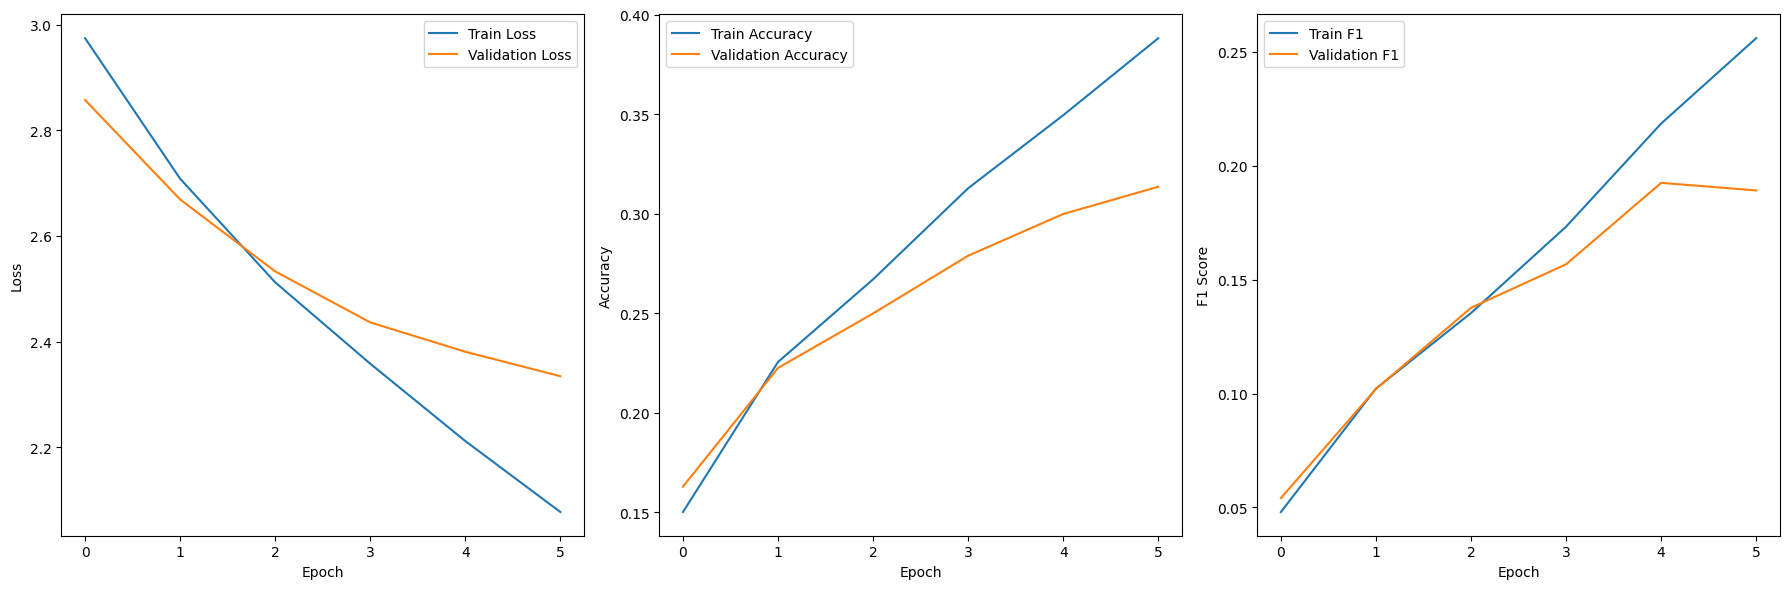

In [176]:
# 로그 데이터 읽기
metrics = pd.read_csv('/content/CancerSubtypesAI/logs/single_aa_embedding_model/version_0/metrics.csv')

# 전체 그래프 크기 설정
plt.figure(figsize=(18, 6))

# Loss 그래프
plt.subplot(1, 3, 1)
plt.plot(metrics['epoch'][~metrics['train_loss'].isna()],
         metrics['train_loss'][~metrics['train_loss'].isna()],
         label='Train Loss'
         )
plt.plot(metrics['epoch'][~metrics['val_loss'].isna()],
         metrics['val_loss'][~metrics['val_loss'].isna()],
         label='Validation Loss'
         )
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Accuracy 그래프
plt.subplot(1, 3, 2)
plt.plot(metrics['epoch'][~metrics['train_acc'].isna()],
         metrics['train_acc'][~metrics['train_acc'].isna()],
         label='Train Accuracy'
         )
plt.plot(metrics['epoch'][~metrics['val_acc'].isna()],
         metrics['val_acc'][~metrics['val_acc'].isna()],
         label='Validation Accuracy'
         )
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# F1-Score 그래프
plt.subplot(1, 3, 3)
plt.plot(metrics['epoch'][~metrics['train_f1'].isna()],
         metrics['train_f1'][~metrics['train_f1'].isna()],
         label='Train F1'
         )
plt.plot(metrics['epoch'][~metrics['val_f1'].isna()],
         metrics['val_f1'][~metrics['val_f1'].isna()],
         label='Validation F1'
         )
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.legend()

# 그래프 모두 표시
plt.tight_layout()
plt.show()

In [178]:
# 저장된 Best Checkpoint 불러오기
best_model = GeneMutationModel(num_genes, num_types, embedding_dim, num_features, hidden_dim, num_classes)
checkpoint = torch.load('checkpoints/single-aa-emdedding-model-best-checkpoint.ckpt')

# 모델에 파라미터 로드
best_model.load_state_dict(checkpoint['state_dict'])

# GPU 사용 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
best_model.to(device)
best_model.eval()

<ipython-input-178-00a9b450dca1>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('checkpoints/single-aa-emdedding-model-best-checkpoint.ckpt')


GeneMutationModel(
  (gene_embedding): Embedding(4385, 64, padding_idx=0)
  (type_embedding): Embedding(8, 64, padding_idx=0)
  (feature_fc): Linear(in_features=12, out_features=64, bias=True)
  (fc): Sequential(
    (0): Linear(in_features=192, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=26, bias=True)
  )
  (criterion): CrossEntropyLoss()
  (train_f1): MulticlassF1Score()
  (val_f1): MulticlassF1Score()
  (test_f1): MulticlassF1Score()
)

In [179]:
all_preds = []
all_targets = []

# 검증 세트에 대한 평가
with torch.no_grad():
    for batch in val_loader:
        inputs = batch['sample'].to(device)
        targets = batch['target'].to(device)

        outputs = best_model(inputs)
        preds = torch.argmax(outputs, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_targets.extend(targets.cpu().numpy())

# Accuracy와 F1-score 계산
acc = accuracy_score(all_targets, all_preds)
f1 = f1_score(all_targets, all_preds, average='macro')

print(f"Validation Accuracy: {acc:.4f}")
print(f"Validation F1 Score: {f1:.4f}")

Validation Accuracy: 0.2998
Validation F1 Score: 0.2154
